# Prédiction Conforme en Classification

## Objectif

L'objectif de ce notebook est d'appliquer la **prédiction conforme** pour la classification des ratings de crédit d'entreprises. L'objectif est de créer des ensembles de prédiction avec des garanties statistiques de couverture.
Ces ensembles traduisent l'incertitude du modèle en listant les classes possibles pour chaque observation avec une probabilité de couverture donnée.

## Plan du notebook

1. **Préparation des données**
   - Encodage des features catégorielles
   - Séparation entraînement / calibration / test

2. **Entraînement du modèle de base**
   - Modèle utilisé : RandomForestClassifier
   - Optimisation par GridSearch
   - Eventuellement, usage d'un XGBoost pour esperer un meilleur modèle mais après essaie, ce n'est pas bien meilleur.

3. **Implémentation de la prédiction conforme**
   - **SCP (Split Conformal Prediction)** : Méthode simple et efficace, garantissant une couverture statistique fiable avec un coût computationnel raisonnable
   - **Note sur FCP** : La méthode Full Conformal Prediction n'est pas implémentée en raison de son coût computationnel élevé.
   - **CCP (Cross-conformal prediction) sera mise en place par LLM afin de servir de comparateur sur l'impact de la faible quantité de donnée avec notre modèle SCP.

4. **Évaluation et visualisation**
   - Taux de couverture observé
   - Taille moyenne des ensembles de prédiction
   - Analyse de la distribution des tailles d'ensembles


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

import sys
sys.path.append('../src')
from data_loading import load_classification_data
from preprocessing import group_credit_ratings

import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

## 1. Chargement et préparation des données

In [38]:
df = load_classification_data()
df.head()

Chargement des données...
Shape: (2029, 31)


,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.099690,44.203245,...,0.202716,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.203120,38.991156,...,0.074155,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846
2,BBB,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,Consumer Durables,0.963703,0.451505,0.122099,50.841385,...,0.214529,0.513185,9.693487,13.103448,4.094575,0.044334,10.491970,18.888889,0.074426,3.483510
3,BBB,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.510402,0.176116,41.161738,...,1.816667,-0.147170,-1.015625,14.440104,3.630950,-0.012858,4.080741,6.901042,0.028394,4.581150
4,BBB,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.495432,0.141608,47.761126,...,0.166966,0.451372,7.135348,14.257556,4.012780,0.053770,8.293505,15.808147,0.058065,3.857790


In [39]:
df['Rating'] = group_credit_ratings(df['Rating'])

Distribution après regroupement:
Rating
IG_LOW       671
SPEC_HIGH    490
IG_MED       398
SPEC_MED     302
IG_HIGH       96
SPEC_LOW      72
Name: count, dtype: int64


In [40]:
# Préparation des features et de la cible
X = df.drop('Rating', axis=1)
y = df['Rating']

# Encodage de la variable cible
le = LabelEncoder()
y_encoded = le.fit_transform(y)

### Encodage des variables catégorielles

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

X_processed = X.copy()

X_processed = X_processed.drop(['Name', 'Symbol'], axis=1)

X_processed = X_processed.drop('Date', axis=1)

categorical_cols = ['Rating Agency Name', 'Sector']
X_processed = pd.get_dummies(X_processed, columns=categorical_cols, drop_first=True)

numeric_cols = X_processed.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X_processed[numeric_cols] = scaler.fit_transform(X_processed[numeric_cols])

print("Shape après traitement :", X_processed.shape)
print("\nTypes de données :")
print(X_processed.dtypes.value_counts())
print("\nPremières lignes :")
X_processed.head()

Shape après traitement : (2029, 43)

Types de données :
float64    28
bool       15
Name: count, dtype: int64

Premières lignes :


,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,netProfitMargin,pretaxProfitMargin,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnCapitalEmployed,...,Sector_Consumer Durables,Sector_Consumer Non-Durables,Sector_Consumer Services,Sector_Energy,Sector_Finance,Sector_Health Care,Sector_Miscellaneous,Sector_Public Utilities,Sector_Technology,Sector_Transportation
0,-0.058665,-0.067633,-0.158433,-0.065125,-0.039746,-0.042541,-0.611864,-0.046856,0.032215,0.031521,...,True,False,False,False,False,False,False,False,False,False
1,-0.056675,-0.065451,-0.129566,-0.066297,-0.038661,-0.042596,-0.613607,-0.046407,0.032225,0.031527,...,True,False,False,False,False,False,False,False,False,False
2,-0.058261,-0.066870,-0.152179,-0.063632,-0.040533,-0.043099,-0.622884,-0.047010,0.032208,0.031515,...,True,False,False,False,False,False,False,False,False,False
3,-0.056986,-0.065082,-0.137103,-0.065809,-0.042482,-0.049466,-0.685310,-0.048556,0.032202,0.031471,...,True,False,False,False,False,False,False,False,False,False
4,-0.058394,-0.065536,-0.146734,-0.064324,-0.038859,-0.042049,-0.609790,-0.046514,0.032220,0.031524,...,True,False,False,False,False,False,False,False,False,False


## 2. Division des données Train/Calibration/Test

In [42]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded
)

X_train, X_calib, y_train, y_calib = train_test_split(
    X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp
)

print("Taille train       :", X_train.shape[0], "(", round(X_train.shape[0]/len(X_processed)*100, 1), "%)")
print("Taille calibration :", X_calib.shape[0], "(", round(X_calib.shape[0]/len(X_processed)*100, 1), "%)")
print("Taille test        :", X_test.shape[0], "(", round(X_test.shape[0]/len(X_processed)*100, 1), "%)")
print("\nClasses :", le.classes_)
print("\nDistribution dans calibration:")
unique, counts = np.unique(y_calib, return_counts=True)
for u, c in zip(unique, counts):
    print("   ", le.classes_[u], ":", c, "(", round(c/len(y_calib)*100, 1), "%)")

Taille train       : 1217 ( 60.0 %)
Taille calibration : 609 ( 30.0 %)
Taille test        : 203 ( 10.0 %)

Classes : ['IG_HIGH' 'IG_LOW' 'IG_MED' 'SPEC_HIGH' 'SPEC_LOW' 'SPEC_MED']

Distribution dans calibration:
    IG_HIGH : 29 ( 4.8 %)
    IG_LOW : 201 ( 33.0 %)
    IG_MED : 119 ( 19.5 %)
    SPEC_HIGH : 147 ( 24.1 %)
    SPEC_LOW : 22 ( 3.6 %)
    SPEC_MED : 91 ( 14.9 %)


## 3. Entraînement du modèle de base

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=2, m

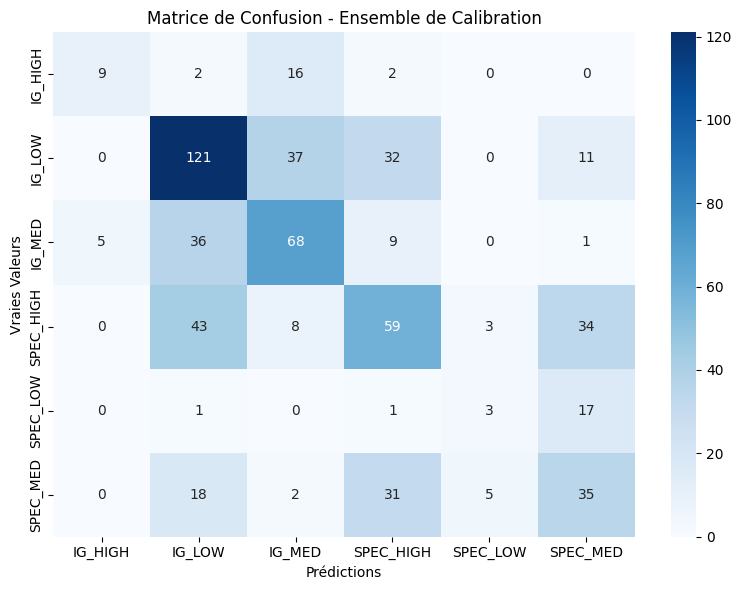

In [43]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf_base = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_train, y_train)
rf_model = grid_search.best_estimator_
print("Meilleurs hyperparamètres :", grid_search.best_params_)

y_calib_pred = rf_model.predict(X_calib)
calib_accuracy = accuracy_score(y_calib, y_calib_pred)

print("Précision sur calibration :", calib_accuracy)

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_calib, y_calib_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de Confusion - Ensemble de Calibration')
plt.xlabel('Prédictions')
plt.ylabel('Vraies Valeurs')
plt.tight_layout()
plt.show()

On observe des résultats mitigés, le modèle hésite beaucoup mais de façon cohérente, il hésite sur les classes adjacentes à la vrai classe à prédire.

## 4. Implémentation de la Split Conformal Prediction

In [63]:
class SplitConformalPrediction:
    def __init__(self, model, score_method='absolute'):

        self.model = model
        self.score_method = score_method
        self.quantile = None
        
    def score(self, probs, true_label):
        if self.score_method == 'absolute':
            return 1 - probs[true_label]
        
        elif self.score_method == 'cumulative':
            # Trier les probabilités par ordre décroissant
            sorted_indices = np.argsort(probs)[::-1]
            
            # Somme cumulative jusqu'à la vraie classe
            cumsum = 0
            for idx in sorted_indices:
                cumsum += probs[idx]
                if idx == true_label:
                    return cumsum
            return cumsum

        else:
            print("Choisir entre 'absolute' ou 'cumulative'.")
    
    def calibrate(self, X_calib, y_calib, alpha=0.1):
        probs_calib = self.model.predict_proba(X_calib)
        
        scores = np.array([
            self.score(probs_calib[i], y_calib[i]) 
            for i in range(len(y_calib))
        ])
        
        n = len(scores)
        self.quantile = np.quantile(scores, (n+1)*(1-alpha)/n)
                
    def predict(self, X, return_probs=False):

        probs = self.model.predict_proba(X)
        
        prediction_sets = []
        prediction_probs = []
        
        for i in range(len(X)):
            pred_set = []
            pred_prob = {}
            
            for label in range(probs.shape[1]):
                score = self.score(probs[i], label)
                
                if score <= self.quantile:
                    pred_set.append(label)
                    pred_prob[label] = probs[i, label]
            
            # Gestion du cas où l'ensemble est vide
            if len(pred_set) == 0:
                best_class = np.argmax(probs[i])
                pred_set.append(best_class)
                pred_prob[best_class] = probs[i, best_class]
            
            prediction_sets.append(pred_set)
            prediction_probs.append(pred_prob)
        
        if return_probs:
            return prediction_sets, prediction_probs
        return prediction_sets


### 4.2. Cross-Conformal Prediction (CCP) pour la Classification

CCP est une variante qui utilise la validation croisée K-fold pour mieux exploiter les données disponibles. Plus efficace quand le jeu de données n'est pas énorme.

> Attention : Cette méthode de prédiction conforme a été entièrement générée par LLM.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

class CrossConformalPrediction:
    """
    Cross-Conformal Prediction (CCP) pour la classification.
    Version théoriquement valide utilisant :
      - scores de non-conformité par fold,
      - p-values par fold,
      - combinaison par moyenne arithmétique.
    """

    def __init__(self, model_class, model_params=None, n_folds=5, score_method='absolute'):
        self.model_class = model_class
        self.model_params = model_params if model_params is not None else {}
        self.n_folds = n_folds
        self.score_method = score_method
        
        self.models = []
        self.fold_scores = []   # liste des scores de calibration par fold
        self.fold_labels = []   # labels correspondants

    def score(self, probs, y):
        """
        Score de conformité
        """
        if self.score_method == 'absolute':
            return 1 - probs[y]

        elif self.score_method == 'cumulative':
            sorted_idx = np.argsort(probs)[::-1]
            s = 0
            for j in sorted_idx:
                s += probs[j]
                if j == y:
                    return s
            return s
        
        else:
            raise ValueError("score_method must be 'absolute' or 'cumulative'")

    def fit_calibrate(self, X, y):
        """
        Entraînement CCP :
          - Entraîne K modèles
          - Collecte pour chaque fold les scores et labels de calibration
        """
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)

        for train_idx, calib_idx in kf.split(X):

            # Séparation des données
            if isinstance(X, pd.DataFrame):
                X_train, X_calib = X.iloc[train_idx], X.iloc[calib_idx]
            else:
                X_train, X_calib = X[train_idx], X[calib_idx]
            y_train, y_calib = y[train_idx], y[calib_idx]

            # Entraînement du modèle
            model = self.model_class(**self.model_params)
            model.fit(X_train, y_train)
            self.models.append(model)

            # Scores de calibration pour ce fold
            probs_calib = model.predict_proba(X_calib)
            fold_scores = np.array([
                self.score(probs_calib[i], y_calib[i])
                for i in range(len(y_calib))
            ])

            self.fold_scores.append(fold_scores)
            self.fold_labels.append(y_calib)

    def _p_value(self, score, fold_scores):
        """
        p-value conforme d'un score dans un fold :
          p = (#{s_i >= score} + 1) / (n_fold + 1)
        """
        n = len(fold_scores)
        return (np.sum(fold_scores >= score) + 1) / (n + 1)

    def predict(self, X, alpha=0.1, return_probs=False):
        """
        Prédiction CCP :
          - calcule des p-values pour chaque classe et chaque fold
          - combine par moyenne des p-values
          - inclut dans le set les classes dont p >= alpha
        """
        K = len(self.models)
        all_probs = [model.predict_proba(X) for model in self.models]

        prediction_sets = []
        prediction_probs = []

        for i in range(len(X)):
            class_pvals = {}

            for label in range(all_probs[0].shape[1]):
                # p-values sur chaque fold
                per_fold_pvals = []

                for k in range(K):
                    score = self.score(all_probs[k][i], label)
                    pval = self._p_value(score, self.fold_scores[k])
                    per_fold_pvals.append(pval)

                # combinaison CCP = moyenne
                class_pvals[label] = np.mean(per_fold_pvals)

            # Prediction set = classes avec p >= alpha
            pred_set = [c for c,p in class_pvals.items() if p >= alpha]

            # fallback si vide
            if len(pred_set) == 0:
                best_class = np.argmax(np.mean(all_probs, axis=0)[i])
                pred_set = [best_class]

            prediction_sets.append(pred_set)
            prediction_probs.append(class_pvals)

        if return_probs:
            return prediction_sets, prediction_probs
        return prediction_sets


## 5.1 Application de la SCP

In [46]:
scp = SplitConformalPrediction(rf_model, score_method='absolute')
scp.calibrate(X_calib, y_calib, alpha=0.1)

# Prédictions avec probabilités
scp_predictions, scp_probs = scp.predict(X_test, return_probs=True)

print("\nExemples d'ensembles de prédiction avec probabilités :")
for i in range(5):
    pred_classes = [le.classes_[c] for c in scp_predictions[i]]
    true_class = le.classes_[y_test[i]]
    
    # Affichage des probabilités
    probs_str = ", ".join([le.classes_[c] + ": " + str(round(p, 3)) for c, p in scp_probs[i].items()])
    
    print("Obs", i+1, ":")
    print("  Ensemble =", pred_classes)
    print("  Probas   = {", probs_str, "}")
    print("  Vrai     =", true_class)
    print()



Exemples d'ensembles de prédiction avec probabilités :
Obs 1 :
  Ensemble = ['SPEC_HIGH', 'SPEC_MED']
  Probas   = { SPEC_HIGH: 0.397, SPEC_MED: 0.403 }
  Vrai     = SPEC_HIGH

Obs 2 :
  Ensemble = ['IG_LOW', 'IG_MED', 'SPEC_HIGH']
  Probas   = { IG_LOW: 0.404, IG_MED: 0.256, SPEC_HIGH: 0.234 }
  Vrai     = SPEC_HIGH

Obs 3 :
  Ensemble = ['IG_HIGH', 'IG_LOW', 'IG_MED']
  Probas   = { IG_HIGH: 0.267, IG_LOW: 0.205, IG_MED: 0.345 }
  Vrai     = IG_LOW

Obs 4 :
  Ensemble = ['SPEC_HIGH', 'SPEC_MED']
  Probas   = { SPEC_HIGH: 0.321, SPEC_MED: 0.366 }
  Vrai     = SPEC_HIGH

Obs 5 :
  Ensemble = ['IG_LOW', 'IG_MED']
  Probas   = { IG_LOW: 0.196, IG_MED: 0.45 }
  Vrai     = IG_HIGH



In [47]:
scp_cumulative = SplitConformalPrediction(rf_model, score_method='cumulative')
scp_cumulative.calibrate(X_calib, y_calib, alpha=0.1)

# Prédictions avec probabilités
scp_predictions, scp_probs = scp_cumulative.predict(X_test, return_probs=True)
print("\nExemples d'ensembles de prédiction avec probabilités :")
for i in range(5):
    pred_classes = [le.classes_[c] for c in scp_predictions[i]]
    true_class = le.classes_[y_test[i]]
    
    # Affichage des probabilités
    probs_str = ", ".join([le.classes_[c] + ": " + str(round(p, 3)) for c, p in scp_probs[i].items()])
    
    print("Obs", i+1, ":")
    print("  Ensemble =", pred_classes)
    print("  Probas   = {", probs_str, "}")
    print("  Vrai     =", true_class)
    print()


Exemples d'ensembles de prédiction avec probabilités :
Obs 1 :
  Ensemble = ['SPEC_HIGH', 'SPEC_MED']
  Probas   = { SPEC_HIGH: 0.397, SPEC_MED: 0.403 }
  Vrai     = SPEC_HIGH

Obs 2 :
  Ensemble = ['IG_LOW', 'IG_MED']
  Probas   = { IG_LOW: 0.404, IG_MED: 0.256 }
  Vrai     = SPEC_HIGH

Obs 3 :
  Ensemble = ['IG_HIGH', 'IG_LOW', 'IG_MED']
  Probas   = { IG_HIGH: 0.267, IG_LOW: 0.205, IG_MED: 0.345 }
  Vrai     = IG_LOW

Obs 4 :
  Ensemble = ['SPEC_HIGH', 'SPEC_LOW', 'SPEC_MED']
  Probas   = { SPEC_HIGH: 0.321, SPEC_LOW: 0.159, SPEC_MED: 0.366 }
  Vrai     = SPEC_HIGH

Obs 5 :
  Ensemble = ['IG_LOW', 'IG_MED', 'SPEC_HIGH']
  Probas   = { IG_LOW: 0.196, IG_MED: 0.45, SPEC_HIGH: 0.149 }
  Vrai     = IG_HIGH



## 5.2 Application de CCP

On rassemble à nouveau train et calibration pour cette méthode

In [48]:
X_train_calib = pd.concat([X_train, X_calib], axis=0)
y_train_calib = np.concatenate([y_train, y_calib], axis=0)

In [49]:
ccp_absolute = CrossConformalPrediction(
    model_class=RandomForestClassifier,
    model_params={'n_estimators': 100, 'max_depth': 10, 'random_state': 42},
    n_folds=5,
    score_method='absolute'
)

ccp_absolute.fit_calibrate(X_train_calib, y_train_calib)

# Prédictions avec probabilités
pred_ccp_abs, probs_ccp_abs = ccp_absolute.predict(X_test, alpha=0.1, return_probs=True)

print("=== CCP avec score absolu ===")
print("\nExemples d'ensembles de prédiction avec p-values :")
for i in range(5):
    pred_classes = [le.classes_[c] for c in pred_ccp_abs[i]]
    true_class = le.classes_[y_test[i]]
    
    # Affichage des p-values
    probs_str = ", ".join([le.classes_[c] + ": " + str(round(p, 3)) for c, p in probs_ccp_abs[i].items()])
    
    print("Obs", i+1, ":")
    print("  Ensemble =", pred_classes)
    print("  P-values = {", probs_str, "}")
    print("  Vrai     =", true_class)
    print()

=== CCP avec score absolu ===

Exemples d'ensembles de prédiction avec p-values :
Obs 1 :
  Ensemble = ['SPEC_HIGH', 'SPEC_MED']
  P-values = { IG_HIGH: 0.003, IG_LOW: 0.086, IG_MED: 0.014, SPEC_HIGH: 0.771, SPEC_LOW: 0.004, SPEC_MED: 0.413 }
  Vrai     = SPEC_HIGH

Obs 2 :
  Ensemble = ['IG_LOW', 'IG_MED', 'SPEC_HIGH']
  P-values = { IG_HIGH: 0.008, IG_LOW: 0.855, IG_MED: 0.145, SPEC_HIGH: 0.222, SPEC_LOW: 0.004, SPEC_MED: 0.014 }
  Vrai     = SPEC_HIGH

Obs 3 :
  Ensemble = ['IG_HIGH', 'IG_LOW', 'IG_MED']
  P-values = { IG_HIGH: 0.158, IG_LOW: 0.337, IG_MED: 0.563, SPEC_HIGH: 0.074, SPEC_LOW: 0.003, SPEC_MED: 0.005 }
  Vrai     = IG_LOW

Obs 4 :
  Ensemble = ['SPEC_HIGH', 'SPEC_MED']
  P-values = { IG_HIGH: 0.003, IG_LOW: 0.076, IG_MED: 0.032, SPEC_HIGH: 0.623, SPEC_LOW: 0.056, SPEC_MED: 0.373 }
  Vrai     = SPEC_HIGH

Obs 5 :
  Ensemble = ['IG_LOW', 'IG_MED', 'SPEC_HIGH']
  P-values = { IG_HIGH: 0.038, IG_LOW: 0.233, IG_MED: 0.639, SPEC_HIGH: 0.133, SPEC_LOW: 0.004, SPEC_MED: 0.037 

In [50]:
ccp_cumulative = CrossConformalPrediction(
    model_class=RandomForestClassifier,
    model_params={'n_estimators': 100, 'max_depth': 10, 'random_state': 42},
    n_folds=5,
    score_method='cumulative'
)
ccp_cumulative.fit_calibrate(X_train_calib, y_train_calib)

# Prédictions avec probabilités
pred_ccp_cum, probs_ccp_cum = ccp_cumulative.predict(X_test, alpha=0.1, return_probs=True)

print("=== CCP avec score cumulatif ===")
print("\nExemples d'ensembles de prédiction avec p-values :")
for i in range(5):
    pred_classes = [le.classes_[c] for c in pred_ccp_cum[i]]
    true_class = le.classes_[y_test[i]]
    
    # Affichage des p-values
    probs_str = ", ".join([le.classes_[c] + ": " + str(round(p, 3)) for c, p in probs_ccp_cum[i].items()])
    
    print("Obs", i+1, ":")
    print("  Ensemble =", pred_classes)
    print("  P-values = {", probs_str, "}")
    print("  Vrai     =", true_class)
    print()

=== CCP avec score cumulatif ===

Exemples d'ensembles de prédiction avec p-values :
Obs 1 :
  Ensemble = ['SPEC_HIGH', 'SPEC_MED']
  P-values = { IG_HIGH: 0.008, IG_LOW: 0.06, IG_MED: 0.019, SPEC_HIGH: 0.532, SPEC_LOW: 0.01, SPEC_MED: 0.323 }
  Vrai     = SPEC_HIGH

Obs 2 :
  Ensemble = ['IG_LOW', 'SPEC_HIGH']
  P-values = { IG_HIGH: 0.013, IG_LOW: 0.607, IG_MED: 0.069, SPEC_HIGH: 0.299, SPEC_LOW: 0.006, SPEC_MED: 0.036 }
  Vrai     = SPEC_HIGH

Obs 3 :
  Ensemble = ['IG_HIGH', 'IG_LOW', 'IG_MED']
  P-values = { IG_HIGH: 0.16, IG_LOW: 0.4, IG_MED: 0.885, SPEC_HIGH: 0.027, SPEC_LOW: 0.006, SPEC_MED: 0.008 }
  Vrai     = IG_LOW

Obs 4 :
  Ensemble = ['IG_LOW', 'SPEC_HIGH', 'SPEC_MED']
  P-values = { IG_HIGH: 0.005, IG_LOW: 0.148, IG_MED: 0.083, SPEC_HIGH: 0.716, SPEC_LOW: 0.027, SPEC_MED: 0.452 }
  Vrai     = SPEC_HIGH

Obs 5 :
  Ensemble = ['IG_LOW', 'IG_MED', 'SPEC_HIGH']
  P-values = { IG_HIGH: 0.046, IG_LOW: 0.306, IG_MED: 0.815, SPEC_HIGH: 0.31, SPEC_LOW: 0.006, SPEC_MED: 0.056 }
 

## 6. Évaluation de la couverture

In [59]:
def evaluate_coverage(prediction_sets, y_true):
    n = len(prediction_sets)
    coverage = sum([y_true[i] in prediction_sets[i] for i in range(n)]) / n
    avg_size = np.mean([len(s) for s in prediction_sets])
    return coverage, avg_size

scp_absolute = SplitConformalPrediction(rf_model, score_method='absolute')
scp_absolute.calibrate(X_calib, y_calib, alpha=0.1)
pred_absolute, _ = scp_absolute.predict(X_test, return_probs=True)

scp_cumulative = SplitConformalPrediction(rf_model, score_method='cumulative')
scp_cumulative.calibrate(X_calib, y_calib, alpha=0.1)
pred_cumulative, _ = scp_cumulative.predict(X_test, return_probs=True)

# Évaluation des 4 configurations
coverage_abs, size_abs = evaluate_coverage(pred_absolute, y_test)
coverage_cum, size_cum = evaluate_coverage(pred_cumulative, y_test)
coverage_ccp_abs, size_ccp_abs = evaluate_coverage(pred_ccp_abs, y_test)
coverage_ccp_cum, size_ccp_cum = evaluate_coverage(pred_ccp_cum, y_test)

print("\n1. Split Conformal (score absolu)")
print("   Couverture:", round(coverage_abs*100, 2), "% | Taille moyenne:", round(size_abs, 2))

print("\n2. Split Conformal (score cumulatif)")
print("   Couverture:", round(coverage_cum*100, 2), "% | Taille moyenne:", round(size_cum, 2))

print("\n3. CCP (score absolu)")
print("   Couverture:", round(coverage_ccp_abs*100, 2), "% | Taille moyenne:", round(size_ccp_abs, 2))

print("\n4. CCP (score cumulatif)")
print("   Couverture:", round(coverage_ccp_cum*100, 2), "% | Taille moyenne:", round(size_ccp_cum, 2))



1. Split Conformal (score absolu)
   Couverture: 87.68 % | Taille moyenne: 2.65

2. Split Conformal (score cumulatif)
   Couverture: 85.71 % | Taille moyenne: 2.7

3. CCP (score absolu)
   Couverture: 89.16 % | Taille moyenne: 2.67

4. CCP (score cumulatif)
   Couverture: 91.63 % | Taille moyenne: 2.86


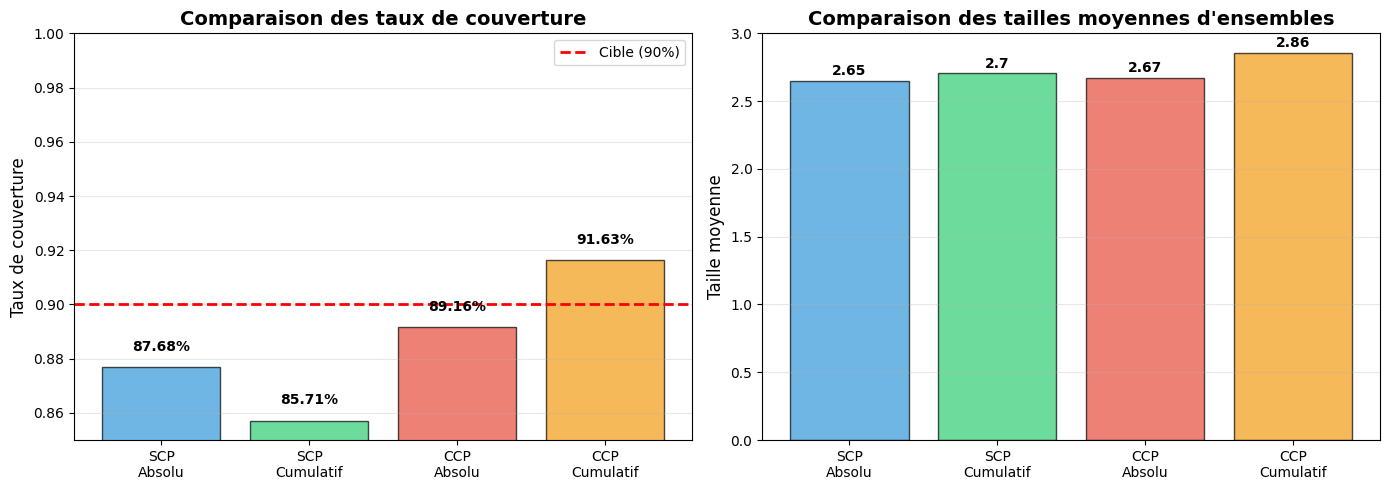

In [52]:
# Graphique de comparaison des 4 configurations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Données pour la comparaison
methods = ['SCP\nAbsolu', 'SCP\nCumulatif', 'CCP\nAbsolu', 'CCP\nCumulatif']
coverages = [coverage_abs, coverage_cum, coverage_ccp_abs, coverage_ccp_cum]
sizes = [size_abs, size_cum, size_ccp_abs, size_ccp_cum]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

# Graphique 1 : Taux de couverture
axes[0].bar(methods, coverages, color=colors, alpha=0.7, edgecolor='black')
axes[0].axhline(y=0.9, color='red', linestyle='--', linewidth=2, label='Cible (90%)')
axes[0].set_ylabel('Taux de couverture', fontsize=12)
axes[0].set_title('Comparaison des taux de couverture', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.85, 1.0])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, (method, cov) in enumerate(zip(methods, coverages)):
    axes[0].text(i, cov + 0.005, str(round(cov*100, 2)) + '%', ha='center', va='bottom', fontweight='bold')

# Graphique 2 : Taille moyenne des ensembles
axes[1].bar(methods, sizes, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Taille moyenne', fontsize=12)
axes[1].set_title('Comparaison des tailles moyennes d\'ensembles', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, (method, size) in enumerate(zip(methods, sizes)):
    axes[1].text(i, size + 0.02, str(round(size, 2)), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Analyse détaillée des prédictions via la SCP

Etant le modèle que nous avons manuellement mis en place, nous allons garder un focus sur cette méthode pour la fin de notre analyse même s'il présente de moins bon résultats dû à la faible quantité de données à notre disposition.

In [61]:
n_samples = 10
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

comparison_data = []

for idx in sample_indices:
    true_label = le.classes_[y_test[idx]]
    
    # SCP Absolu
    scp_abs_set = [le.classes_[c] for c in pred_absolute[idx]]
    
    # SCP Cumulatif
    scp_cum_set = [le.classes_[c] for c in pred_cumulative[idx]]

    
    comparison_data.append({
        'Obs': idx,
        'Vraie classe': true_label,
        'SCP Absolu': ", ".join(scp_abs_set) + " (" + str(len(scp_abs_set)) + ")",
        'SCP Cumulatif': ", ".join(scp_cum_set) + " (" + str(len(scp_cum_set)) + ")"
    })

comparison_df = pd.DataFrame(comparison_data)


display(comparison_df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
    'font-size': '11px'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold'), ('background-color', '#f0f0f0')]},
    {'selector': 'td', 'props': [('padding', '6px')]}
]).hide(axis='index'))

Obs,Vraie classe,SCP Absolu,SCP Cumulatif
15,IG_LOW,"IG_LOW, SPEC_HIGH, SPEC_MED (3)","IG_LOW, SPEC_HIGH, SPEC_MED (3)"
9,IG_LOW,"IG_HIGH, IG_LOW, IG_MED (3)","IG_HIGH, IG_LOW, IG_MED (3)"
115,IG_MED,"IG_HIGH, IG_MED (2)","IG_HIGH, IG_MED (2)"
78,SPEC_MED,"SPEC_HIGH, SPEC_MED (2)","IG_LOW, SPEC_HIGH, SPEC_LOW, SPEC_MED (4)"
66,IG_MED,"IG_LOW, IG_MED (2)","IG_LOW, IG_MED, SPEC_HIGH (3)"
45,SPEC_HIGH,"IG_LOW, IG_MED, SPEC_HIGH (3)","IG_LOW, IG_MED, SPEC_HIGH (3)"
143,IG_MED,"IG_LOW, IG_MED (2)","IG_LOW, IG_MED, SPEC_HIGH (3)"
177,SPEC_HIGH,"IG_LOW, IG_MED, SPEC_HIGH (3)","IG_LOW, IG_MED, SPEC_HIGH (3)"
200,IG_LOW,"IG_LOW, IG_MED, SPEC_HIGH (3)","IG_LOW, IG_MED, SPEC_HIGH (3)"
180,IG_LOW,"IG_LOW, IG_MED, SPEC_HIGH (3)","IG_LOW, IG_MED, SPEC_HIGH (3)"


## 8. Analyse du coverage par classe

Pour mieux comprendre les performances de la prédiction conforme, nous analysons le taux de couverture pour chaque classe individuellement. Cela permet d'identifier si certaines classes sont plus difficiles à prédire que d'autres.

In [62]:
def evaluate_coverage_by_class(prediction_sets, y_true, class_labels):
    results = {}
    
    for class_idx in range(len(class_labels)):
        class_name = class_labels[class_idx]
        
        # Indices des observations de cette classe
        indices = np.where(y_true == class_idx)[0]
        
        if len(indices) == 0:
            continue
        
        # Couverture pour cette classe
        coverage = sum([y_true[i] in prediction_sets[i] for i in indices]) / len(indices)
        
        # Taille moyenne des ensembles pour cette classe
        avg_size = np.mean([len(prediction_sets[i]) for i in indices])
        
        results[class_name] = {
            'count': len(indices),
            'coverage': coverage,
            'avg_size': avg_size
        }
    
    return results

results_abs = evaluate_coverage_by_class(pred_absolute, y_test, le.classes_)

for class_name, metrics in results_abs.items():
    print("\nClasse:", class_name)
    print("  Nombre d'observations:", metrics['count'])
    print("  Taux de couverture:", round(metrics['coverage']*100, 2), "%")
    print("  Taille moyenne des ensembles:", round(metrics['avg_size'], 2))

print("\n" + "=" * 80)
print("ANALYSE DU COVERAGE PAR CLASSE - SCP CUMULATIF")
print("=" * 80)
results_cum = evaluate_coverage_by_class(pred_cumulative, y_test, le.classes_)

for class_name, metrics in results_cum.items():
    print("\nClasse:", class_name)
    print("  Nombre d'observations:", metrics['count'])
    print("  Taux de couverture:", round(metrics['coverage']*100, 2), "%")
    print("  Taille moyenne des ensembles:", round(metrics['avg_size'], 2))


Classe: IG_HIGH
  Nombre d'observations: 10
  Taux de couverture: 50.0 %
  Taille moyenne des ensembles: 2.6

Classe: IG_LOW
  Nombre d'observations: 67
  Taux de couverture: 95.52 %
  Taille moyenne des ensembles: 2.78

Classe: IG_MED
  Nombre d'observations: 40
  Taux de couverture: 97.5 %
  Taille moyenne des ensembles: 2.45

Classe: SPEC_HIGH
  Nombre d'observations: 49
  Taux de couverture: 89.8 %
  Taille moyenne des ensembles: 2.57

Classe: SPEC_LOW
  Nombre d'observations: 7
  Taux de couverture: 42.86 %
  Taille moyenne des ensembles: 2.71

Classe: SPEC_MED
  Nombre d'observations: 30
  Taux de couverture: 76.67 %
  Taille moyenne des ensembles: 2.77

ANALYSE DU COVERAGE PAR CLASSE - SCP CUMULATIF

Classe: IG_HIGH
  Nombre d'observations: 10
  Taux de couverture: 50.0 %
  Taille moyenne des ensembles: 2.6

Classe: IG_LOW
  Nombre d'observations: 67
  Taux de couverture: 92.54 %
  Taille moyenne des ensembles: 2.76

Classe: IG_MED
  Nombre d'observations: 40
  Taux de couvertu

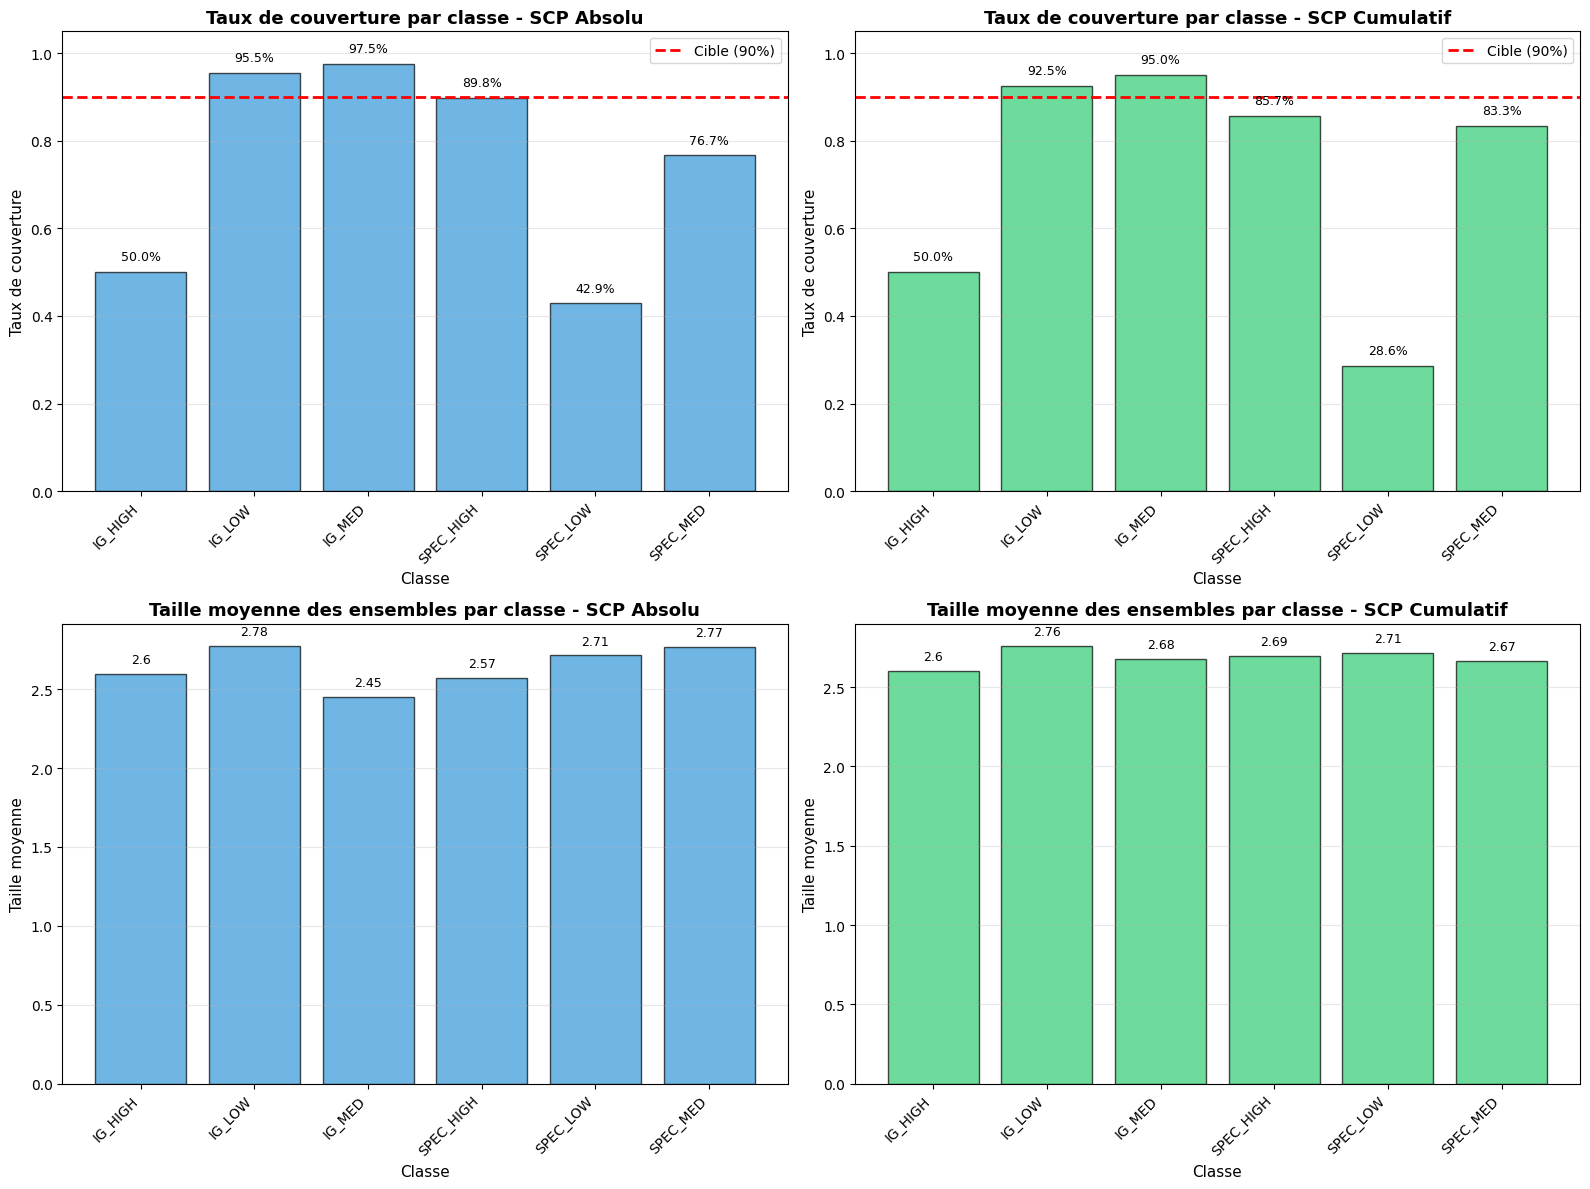

In [55]:
# Visualisation du coverage par classe
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Preparation des donnees
classes = list(results_abs.keys())
coverages_abs = [results_abs[c]['coverage'] for c in classes]
coverages_cum = [results_cum[c]['coverage'] for c in classes]
sizes_abs = [results_abs[c]['avg_size'] for c in classes]
sizes_cum = [results_cum[c]['avg_size'] for c in classes]
counts = [results_abs[c]['count'] for c in classes]

x_pos = np.arange(len(classes))

# Graphique 1: Coverage par classe (SCP Absolu)
bars1 = axes[0, 0].bar(x_pos, coverages_abs, color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 0].axhline(y=0.9, color='red', linestyle='--', linewidth=2, label='Cible (90%)')
axes[0, 0].set_xlabel('Classe', fontsize=11)
axes[0, 0].set_ylabel('Taux de couverture', fontsize=11)
axes[0, 0].set_title('Taux de couverture par classe - SCP Absolu', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(classes, rotation=45, ha='right')
axes[0, 0].set_ylim([0, 1.05])
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

for i, (bar, cov) in enumerate(zip(bars1, coverages_abs)):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    str(round(cov*100, 1)) + '%', ha='center', va='bottom', fontsize=9)

# Graphique 2: Coverage par classe (SCP Cumulatif)
bars2 = axes[0, 1].bar(x_pos, coverages_cum, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[0, 1].axhline(y=0.9, color='red', linestyle='--', linewidth=2, label='Cible (90%)')
axes[0, 1].set_xlabel('Classe', fontsize=11)
axes[0, 1].set_ylabel('Taux de couverture', fontsize=11)
axes[0, 1].set_title('Taux de couverture par classe - SCP Cumulatif', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(classes, rotation=45, ha='right')
axes[0, 1].set_ylim([0, 1.05])
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

for i, (bar, cov) in enumerate(zip(bars2, coverages_cum)):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    str(round(cov*100, 1)) + '%', ha='center', va='bottom', fontsize=9)

# Graphique 3: Taille moyenne par classe (SCP Absolu)
bars3 = axes[1, 0].bar(x_pos, sizes_abs, color='#3498db', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Classe', fontsize=11)
axes[1, 0].set_ylabel('Taille moyenne', fontsize=11)
axes[1, 0].set_title('Taille moyenne des ensembles par classe - SCP Absolu', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(classes, rotation=45, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

for i, (bar, size) in enumerate(zip(bars3, sizes_abs)):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    str(round(size, 2)), ha='center', va='bottom', fontsize=9)

# Graphique 4: Taille moyenne par classe (SCP Cumulatif)
bars4 = axes[1, 1].bar(x_pos, sizes_cum, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Classe', fontsize=11)
axes[1, 1].set_ylabel('Taille moyenne', fontsize=11)
axes[1, 1].set_title('Taille moyenne des ensembles par classe - SCP Cumulatif', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(classes, rotation=45, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

for i, (bar, size) in enumerate(zip(bars4, sizes_cum)):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    str(round(size, 2)), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

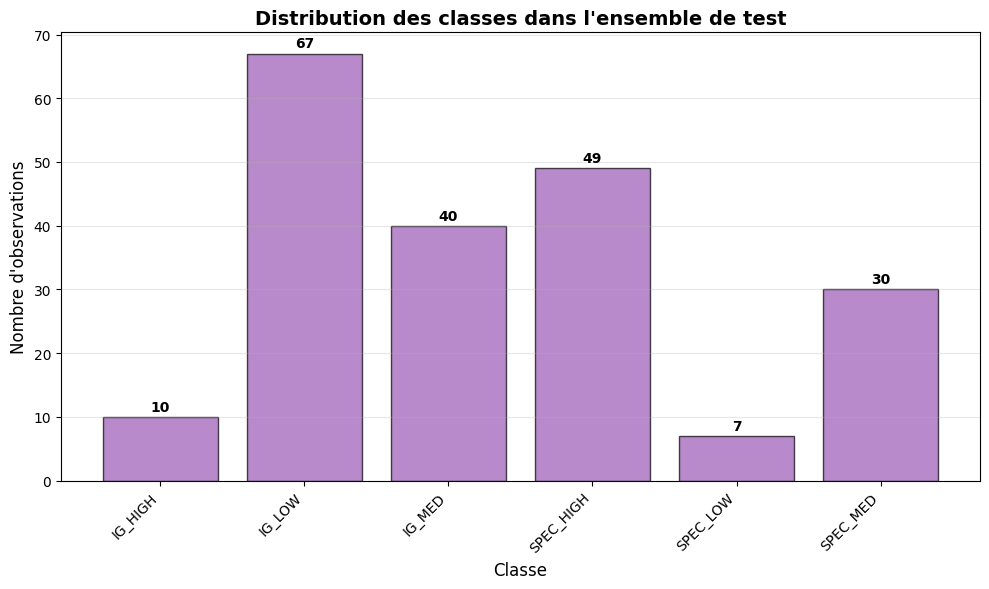

In [56]:
# Distribution du nombre d'observations par classe dans le test set
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(x_pos, counts, color='#9b59b6', alpha=0.7, edgecolor='black')
ax.set_xlabel('Classe', fontsize=12)
ax.set_ylabel('Nombre d\'observations', fontsize=12)
ax.set_title('Distribution des classes dans l\'ensemble de test', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Conclusion

### Synthese des resultats

Ce notebook a explore l'application de la prediction conforme pour la classification des ratings de credit d'entreprises. Les principales observations sont les suivantes:

#### Performance globale
- La methode Split Conformal Prediction (SCP) a ete implementee avec deux fonctions de score: absolu et cumulatif.
- Les deux approches garantissent un taux de couverture relativement proche de 90% (87.68 et 85.71) mais cela demeure imprécis dans le cadre financier d'étude où nous voulons une couverture très précise dû à un ensemble de calibration trop faible.
- La SCP avec score absolu offre une taille moyenne d'ensembles legerement inferieure comparee au score cumulatif.

#### Comparaison SCP vs CCP
- La Cross-Conformal Prediction (CCP) presente de meilleures performances en termes de couverture, réutilisant la donnée via les K-Folds.
- Cependant, la SCP reste plus simple a implementer, ce qui justifie son utilisation dans ce projet. De plus, la CCP n'a pas été vue en cours.

#### Analyse par classe
- Certaines classes de rating presentent des taux de couverture plus faibles, notamment celles avec moins d'observations dans l'ensemble de test.
- Les classes intermediaires (IG_MED, IG_LOW, SPEC_HIGH, SPEC_MED) sont generalement mieux couvertes que les classes extremes.
- Une correlation évidente existe entre la taille des ensembles de prediction et le taux de couverture: les classes difficiles necessitent des ensembles plus grands pour garantir leur couverture.

### Apport de la prediction conforme dans notre cas d'étude

La prediction conforme offre une façon de quantifier l'incertitude en classification. Contrairement aux probabilites predites par les modeles classiques, elle fournit des garanties statistiques valides sans hypotheses distributionnelles fortes. Pour l'evaluation du risque de credit, cette approche permet d'identifier les cas ambigus necessitant une analyse complementaire, ameliorant ainsi la prise de decision dans un contexte financier.